# Melanoma Detection with CNN

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import collections
import Augmentor



In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166



This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r'dt/sc/train')
data_dir_test = pathlib.Path(r'dt/sc/test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

n_classes = len(class_names)
print(n_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

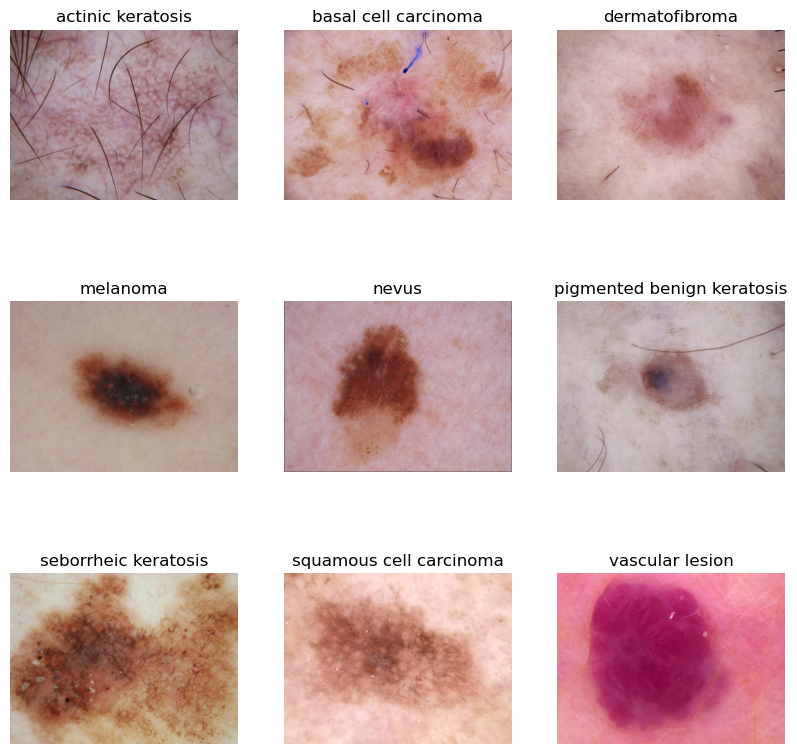

In [9]:
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

In [10]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

<Axes: xlabel='No. of Image', ylabel='Class'>

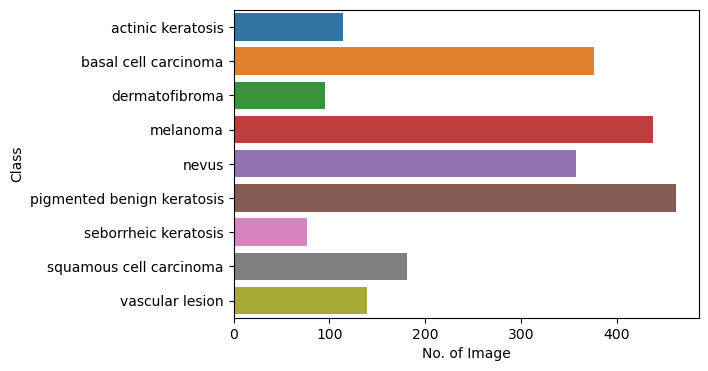

In [11]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

(32, 180, 180, 3)
[4 3 1 3 2 4 7 3 3 2 3 4 3 4 3 5 1 3 5 4 7 1 3 4 8 8 1 4 5 3 8 5]


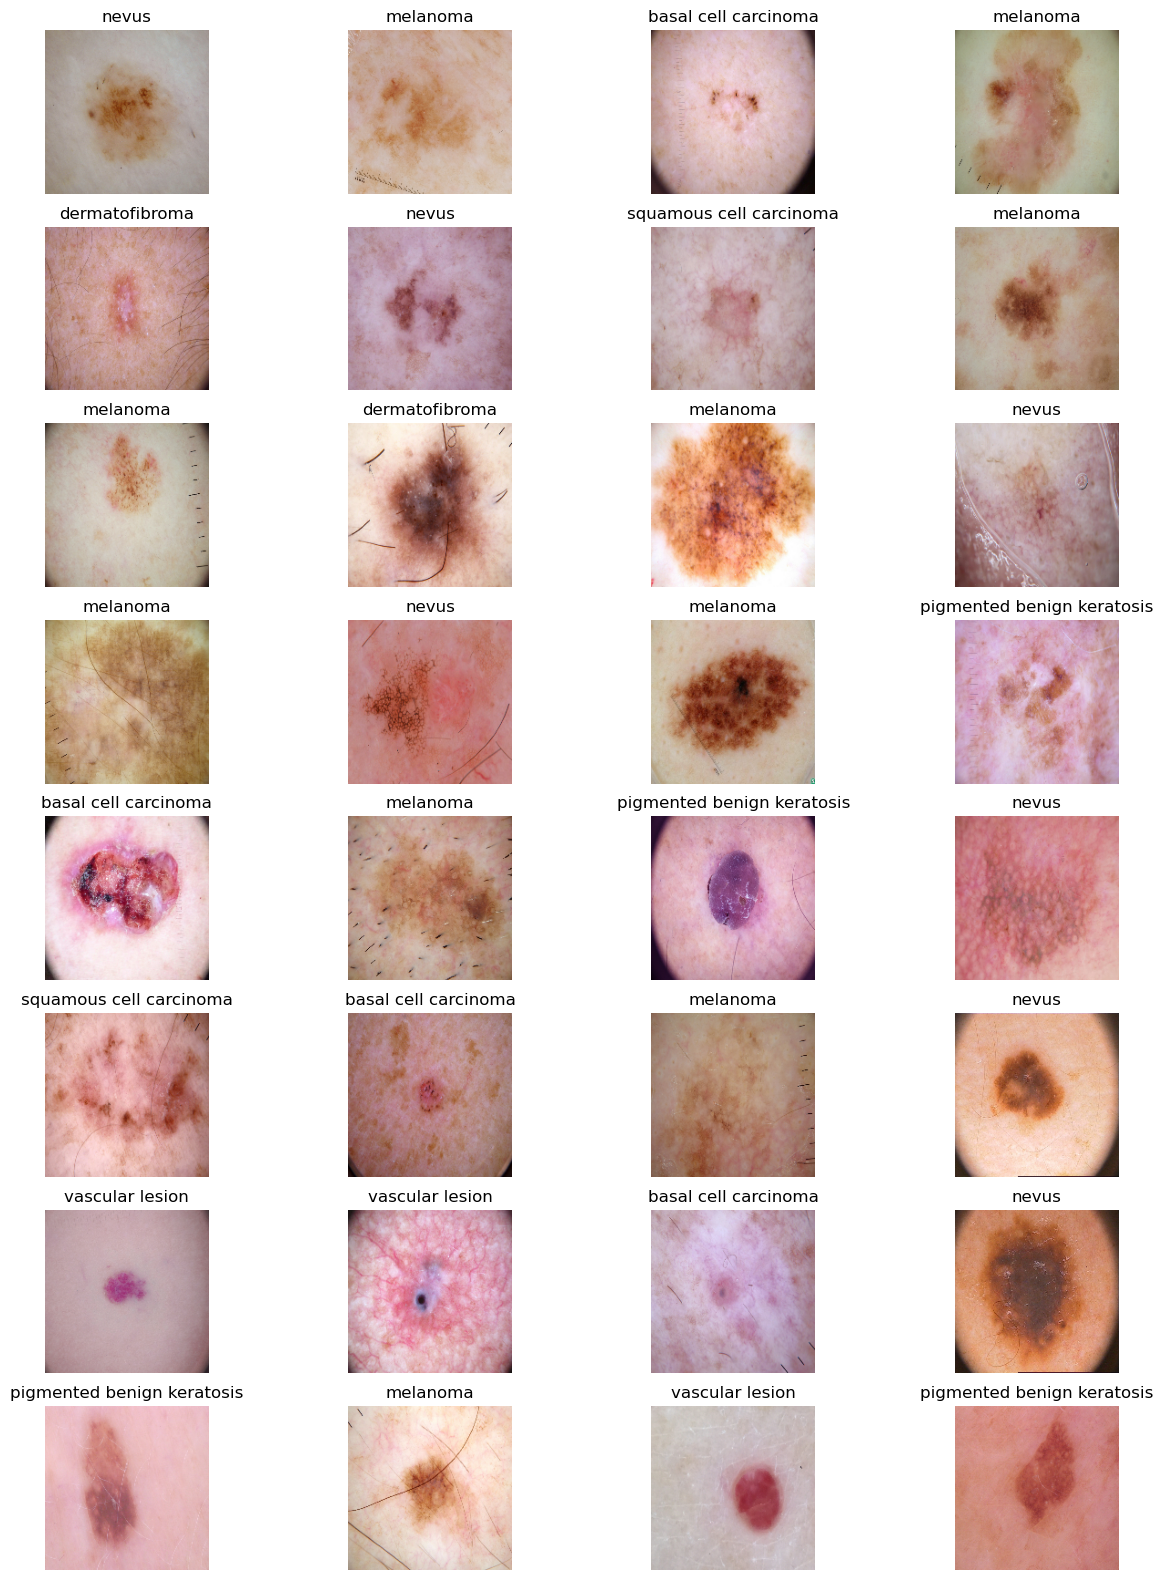

In [13]:

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(15,20))
for image_batch , labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[i]])
    plt.axis('off')

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here

# Define the CNN model


model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

C:\Users\connectonetest\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function

from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [18]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.1992 - loss: 2.0622 - val_accuracy: 0.0435 - val_loss: 2.2186 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - accuracy: 0.1982 - loss: 2.0036 - val_accuracy: 0.1304 - val_loss: 2.2639 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.3100 - loss: 1.8869 - val_accuracy: 0.1739 - val_loss: 2.4147 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 418ms/step - accuracy: 0.2224 - loss: 2.0332 - val_accuracy: 0.0870 - val_loss: 2.4099 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - accuracy: 0.3154 - loss: 1.7901 - val_accuracy: 0.2174 - val_loss: 2.4537 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.3863 - loss: 1.6616 - val_accuracy: 0.1739 - val_loss: 2.2842 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.3943 - loss: 1.

### Visualizing training results

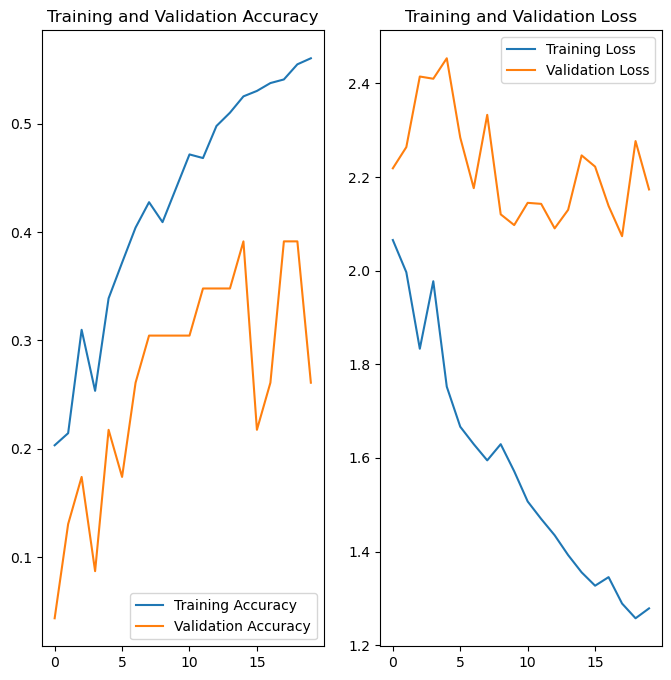

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The Training accuracy is ~55% and validation accuracy is ~38%. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}

# Now assign integer labels to your training data
train_labels = [class_to_label[class_name] for class_name in class_names]


In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

train_labels = train_ds.map(lambda image, label: label)

for images, labels in train_ds.take(1):
    # Print the shape of image tensors and labels
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (32, 180, 180, 3)
Label shape: (32,)


In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
  ]
)

In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define your data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
)


In [24]:
# Convert TensorFlow Dataset to NumPy arrays
# Assuming 'train_ds' yields (image, label) tuples
train_images = []
train_labels_array = []
for images, labels in train_ds:
    train_images.append(images.numpy())  # Convert image tensors to NumPy arrays
    train_labels_array.append(labels.numpy())

train_images = np.concatenate(train_images, axis=0)  # Stack images into a single array
train_labels_array = np.concatenate(train_labels_array, axis=0)

In [25]:
# Apply data augmentation to training data
train_generator = datagen.flow(
    x=train_images,  # NumPy array of images
    y=train_labels_array,  # NumPy array of labels
    batch_size=32,
    shuffle=True
)

### Todo:
### Create the model, compile and train the model


In [26]:
## Your code goes here


model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [27]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 16)     │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 128)      │       247,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,16

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
# Call the function to create and train your model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.2210 - loss: 2.1824 - val_accuracy: 0.0435 - val_loss: 2.2652 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.1832 - loss: 2.0319 - val_accuracy: 0.0435 - val_loss: 2.3141 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.1789 - loss: 2.0375 - val_accuracy: 0.0435 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.2106 - loss: 2.0064 - val_accuracy: 0.0435 - val_loss: 2.3819 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.2043 - loss: 1.9973 - val_accuracy: 0.0435 - val_loss: 2.3285 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1910 - loss: 2.0210
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.1912 - loss: 2.0

### Visualizing the results

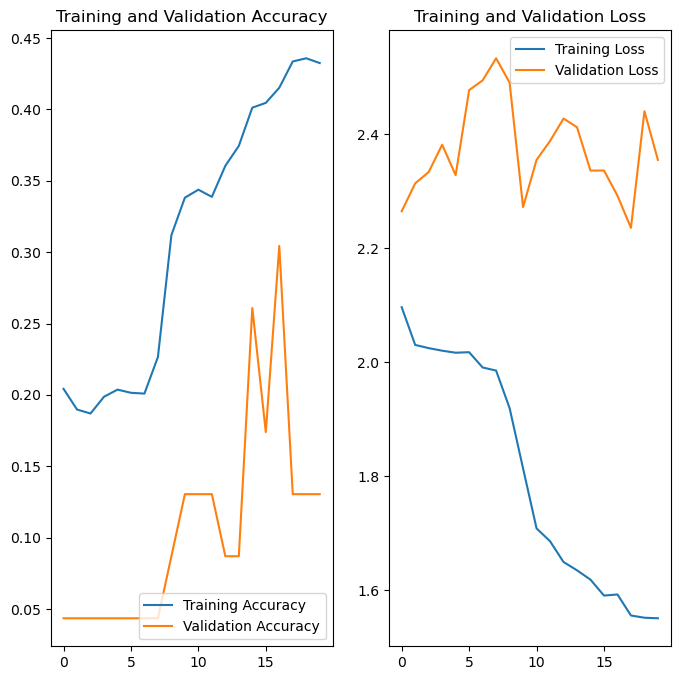

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

No, there is no improvement in the model. It gives a sign of underfit. There is a need to address the Class Imbalance on the model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:

# Assuming you have 'train_labels' as your integer labels (class IDs)
def get_class_distribution(labels):
    class_distribution = collections.Counter(labels)
    return class_distribution

# Example usage:
train_labels = [0, 1, 2, 0, 3, 1, 4, 2, 5, 6,7,8,9]  # Replace with your actual labels
train_ds_class_dist = get_class_distribution(train_labels)

# Print the class distribution
for label, count in train_ds_class_dist.items():
    print(f"Class {label}: {count} instances")

Class 0: 2 instances
Class 1: 2 instances
Class 2: 2 instances
Class 3: 1 instances
Class 4: 1 instances
Class 5: 1 instances
Class 6: 1 instances
Class 7: 1 instances
Class 8: 1 instances
Class 9: 1 instances


In [32]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))

class_diff

Empty DataFrame
Columns: []
Index: []

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis(77)

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis (462)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset= data_dir_train
#print (path_to_training_dataset)
   
for i in class_names:
    # Full path to each class directory
    class_path = os.path.join(path_to_training_dataset, i)
    p = Augmentor.Pipeline(class_path) # Initialize the Augmentor pipeline with the class path
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)  # Augmentation: rotate images
    # Generate 500 samples for each class
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to dt\sc\train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B23F4AF7D0>: 100%|██████████| 500/500 [00:07<00:00, 66.97 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to dt\sc\train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B23386A250>: 100%|██████████| 500/500 [00:08<00:00, 60.14 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to dt\sc\train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B23F4AEBD0>: 100%|██████████| 500/500 [00:07<00:00, 64.89 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to dt\sc\train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B2338E2F90>: 100%|██████████| 500/500 [00:34<00:00, 14.32 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to dt\sc\train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=724x542 at 0x1B23F5792D0>: 100%|██████████| 500/500 [00:31<00:00, 15.65 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to dt\sc\train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B26C282E50>: 100%|██████████| 500/500 [00:07<00:00, 66.52 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to dt\sc\train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B23F4D6710>: 100%|██████████| 500/500 [00:16<00:00, 30.39 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to dt\sc\train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B23FFD5B10>: 100%|██████████| 500/500 [00:08<00:00, 58.13 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to dt\sc\train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B210564610>: 100%|██████████| 500/500 [00:07<00:00, 66.92 Samples/s]


In [35]:


# Assuming 'data_dir_train' should point to your training directory:
data_dir_train = pathlib.Path(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", 
              input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
  ]
)

C:\Users\connectonetest\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


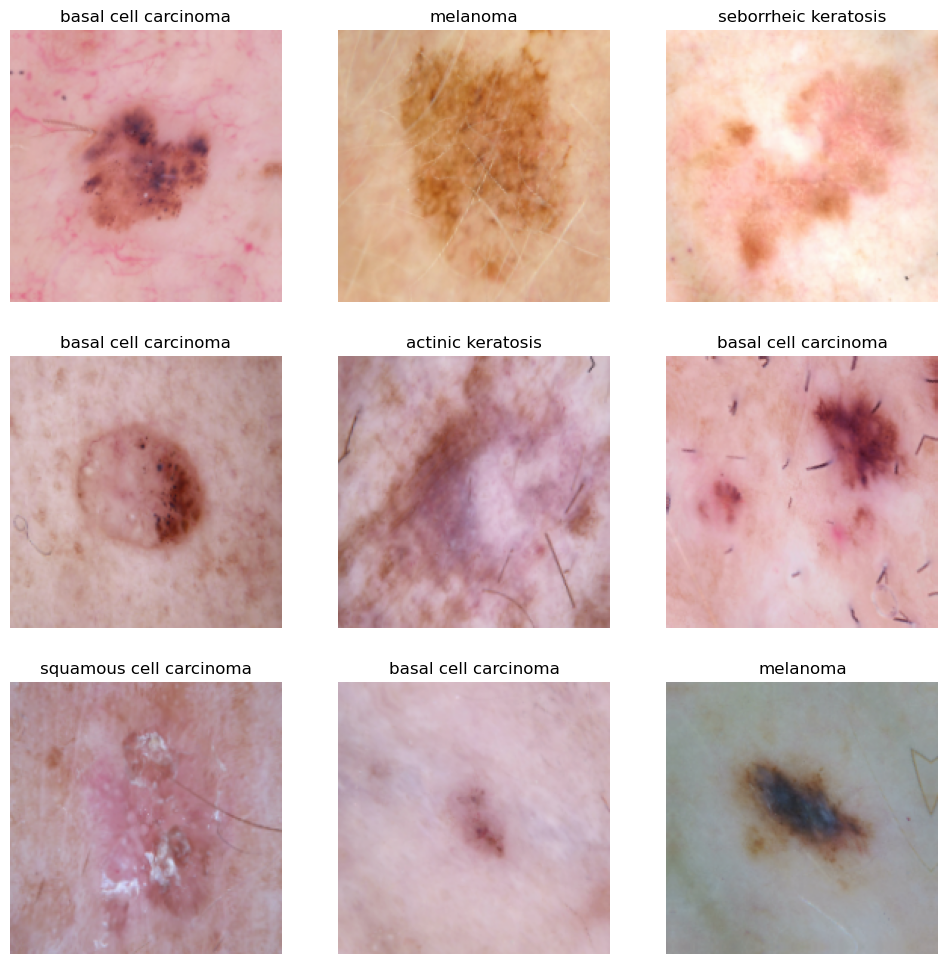

In [38]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
import os
from glob import glob  # Import the glob function
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_94c24f0b-8e5c-4db0-b4a2-54ca954892c3.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a321e3a5-5acd-4f6e-bb6b-60e79de94cbc.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_08df7cf4-fba4-4ece-b188-f989898cdbf4.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_391a0645-7b69-4e7c-9ad7-da590260cc21.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a579294e-5237-4d83-93ef-1372ceade125.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_eb3dd409-4734-4cd1-bf73-b787ddc25441.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025953.jpg_039f6be7-96d6-456c-8401-876a988bb08b.jpg',
 'dt\\sc\\train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025953

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:


original_df = pd.DataFrame({'Path': [], 'Label': []})  # Replace with your actual original DataFrame

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

# Use pd.concat instead of append
new_df = pd.concat([original_df, df2], ignore_index=True)

In [43]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3

#### **Todo:** Create a training dataset

In [45]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
validation_split = 0.2,
  subset = 'validation',  # Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(180, 180),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

num_classes = len(class_names)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust num_classes based on your dataset
])

C:\Users\connectonetest\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [49]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [50]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 303ms/step - accuracy: 0.2441 - loss: 1.9694 - val_accuracy: 0.4113 - val_loss: 1.5425
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.4635 - loss: 1.4070 - val_accuracy: 0.5316 - val_loss: 1.2405
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - accuracy: 0.5229 - loss: 1.2523 - val_accuracy: 0.5612 - val_loss: 1.1607
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.6224 - loss: 1.0052 - val_accuracy: 0.5716 - val_loss: 1.1391
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.6660 - loss: 0.9406 - val_accuracy: 0.6592 - val_loss: 0.9578
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 266ms/step - accuracy: 0.7501 - loss: 0.7058 - val_accuracy: 0.7001 - val_loss: 0.9039
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.8082 - loss: 0.5466 - val_accuracy: 0.7379 - val_loss: 0.7965
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - accuracy: 0.8341 - loss: 0

169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.9483 - loss: 0.1563 - val_accuracy: 0.7981 - val_loss: 1.4996


#### **Todo:**  Visualize the model results

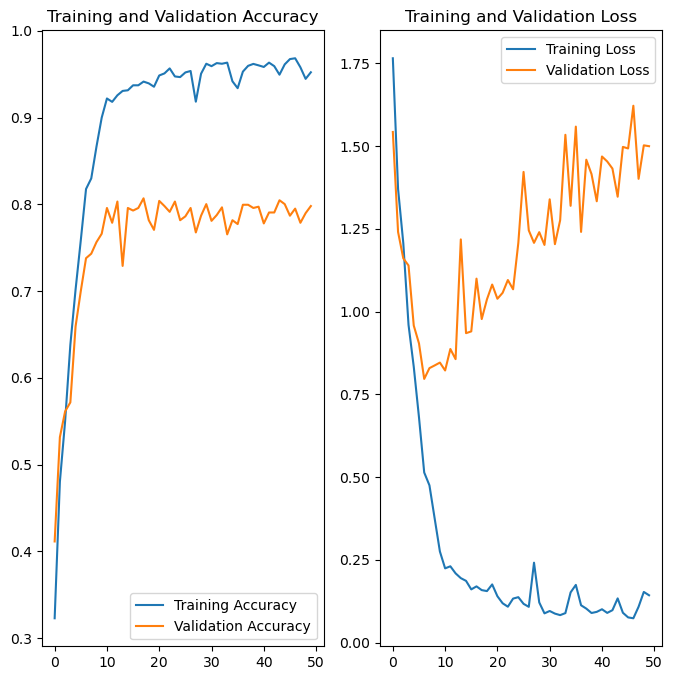

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


    The training accuracy and validation accuracy are almost same. This is a sign of good fit.
    There is significant difference in training loss and validation loss. 
    The class rebalance has helped to overcome the overfitting/underfitting issue.
    The Training accuracy increased to 96% and Validation accuracy is 80% which is good. 
    The model is able to classify the images with 80% accuracy.